# Train Classifier on Simulated Data

Train a classifier on Alex's [simulated data](https://github.com/braingeneers/braingeneers/issues/3). The simulated PNG's with labels have been converted into Tensorflow's native binary format, tfrecords via an [ingest notebook](https://github.com/braingeneers/organoid-net/blob/master/simulated/ingest.ipynb) and stored in the PRP S3/CEPH store so they are publicly accesible.

In [3]:
import os
import json
import requests

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # reproducibility

import tensorflow as tf
# DistributionStrategy is not supported when eager execution is enabled...sigh....
# tf.enable_eager_execution()

# See if we have a GPU - if not check Edit->Notebook Settings for GPU/TPU options
# In a prelimary test the GPU took ~2.5 minutes to train vs. ~4-5 minutes for the TPU,
# but the TPU required less power and therefore is the green choice :-)
print("GPU Available:", tf.test.is_gpu_available())

# TF outputs quite a bit of logging form TFDataset when sourcing from S3
# 0=All, 1=Filter Info, 2=Filter Warning, 3=Filter Error
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

# Simple syntatic sugar for debug vs. train parameters
def debug(debug_param, no_debug_param):
    return debug_param if os.environ.get("DEBUG") else no_debug_param
print(debug("DEBUG: ON", "DEBUG: OFF"))

GPU Available: False
DEBUG: ON


In [4]:
import boto3

bucket_name = "braingeneers"

session = boto3.session.Session(profile_name=os.getenv("AWS_PROFILE"))
bucket = session.resource(
    "s3", endpoint_url=os.getenv("AWS_S3_ENDPOINT")).Bucket(bucket_name)
print("S3 Profile: {} Endpoint: {} Bucket: {}".format(
    os.getenv("AWS_PROFILE"), os.getenv("AWS_S3_ENDPOINT"), bucket_name))

S3 Profile: prp Endpoint: https://s3.nautilus.optiputer.net Bucket: braingeneers


In [5]:
# Read in metadata for a dataset
dataset_name = "simulated"
print("Reading {} dataset".format(dataset_name))

metadata = json.loads(bucket.Object(
    dataset_name + "/metadata.json").get()['Body'].read().decode('utf-8'))
print("Dataset metadata keys:", list(metadata.keys()))
print("{} train and {} test samples with {} labels".format(
    metadata["num_train_examples"], metadata["num_test_examples"], len(metadata["labels"])))

Reading simulated dataset
Dataset metadata keys: ['image_width', 'image_height', 'labels', 'description', 'data_set', 'train_examples_name', 'num_train_examples', 'test_examples_name', 'num_test_examples']
8000 train and 2000 test samples with 49 labels


## Tensor Flow Dataset

For this small of a dataset this is overkill. But it demonstrates how to build a lazy data pipeline with data modification such that it will feed the Tensorflow engine natively at training time. Data augmentation via tf.image.* can easily be added and this general pattern will likely be useful when we have big data sets and video in PRP.

First image shape: (87, 115, 1)


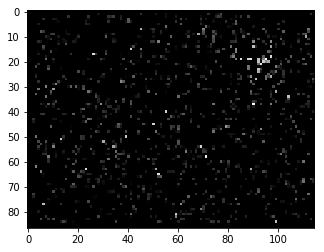

In [11]:
batch_size = 128

def parse_one_example(example):
    example = tf.parse_single_example(example, features = {
        "example": tf.FixedLenFeature([], tf.string),
        "label": tf.FixedLenFeature([], tf.int64)
    })
    
    image = tf.image.decode_png(example["example"], channels=1)
    image = tf.image.resize_images(
        image, [metadata["image_height"] // 4, metadata["image_width"] // 4])
    image = tf.image.per_image_standardization(image)
    
    label = tf.one_hot(example["label"], len(metadata["labels"]))
    
    return image, label

def create_dataset(files, batch_size, num_classes):
    dataset = tf.data.TFRecordDataset(files)
    dataset = dataset.map(parse_one_example, num_parallel_calls=8)
    dataset.cache("tensorflow.cache")
    dataset = dataset.shuffle(8 * num_classes)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)
    return dataset

training_dataset = create_dataset(
    ["s3://braingeneers/{}/{}".format(metadata["data_set"], metadata["train_examples_name"])],
    batch_size, len(metadata["labels"]))
test_dataset = create_dataset(
    ["s3://braingeneers/{}/{}".format(metadata["data_set"], metadata["test_examples_name"])],
    batch_size, len(metadata["labels"]))

# # Display the first image of a batch as a check
examples, labels = training_dataset.make_one_shot_iterator().get_next()

# Non Eager Mode
with tf.Session() as sess:
    first_image = sess.run(examples)[0]

# Eager Mode
# first_image = examples[0].numpy()
    
print("First image shape:", first_image.shape)
plt.imshow(first_image.reshape(first_image.shape[0], first_image.shape[1]), cmap="gray")

## Model and Train

In [12]:
# From https://github.com/mbernico/deep_learning_quick_reference/blob/master/chapter_6/mnist_hyperband_search.py
import numpy as np
import random
from math import log, ceil
from time import time, ctime

class Hyperband:
    def __init__(self, data, get_params_function, try_params_function, max_iter=81):
        self.data = data
        self.get_params = get_params_function
        self.try_params = try_params_function

        self.max_iter = max_iter  # maximum iterations per configuration
        self.eta = 3  # defines configuration downsampling rate (default = 3)

        self.logeta = lambda x: log(x) / log(self.eta)
        self.s_max = int(self.logeta(self.max_iter))
        self.B = (self.s_max + 1) * self.max_iter

        self.results = []  # list of dicts
        self.counter = 0
        self.best_loss = np.inf
        self.best_counter = -1

    # can be called multiple times
    def run(self, skip_last=0):

        for s in list(reversed(range(self.s_max + 1)))[:1 if os.environ.get("DEBUG") else -1]:

            # initial number of configurations
            n = int(ceil(self.B / self.max_iter / (s + 1) * self.eta ** s))

            # initial number of iterations per config
            r = self.max_iter * self.eta ** (-s)

            # n random configurations
            T = [self.get_params() for i in range(n)]

            for i in list(range((s + 1) - int(skip_last)))[:1 if os.environ.get("DEBUG") else -1]:  # changed from s + 1

                # Run each of the n configs for <iterations>
                # and keep best (n_configs / eta) configurations

                n_configs = n * self.eta ** (-i)
                n_iterations = r * self.eta ** (i)

                print("\n*** {} configurations x {:.1f} iterations each".format(
                    n_configs, n_iterations))

                val_losses = []
                early_stops = []

                for t in T[:1 if os.environ.get("DEBUG") else -1]:

                    self.counter += 1
                    print("\n{} | {} | lowest loss so far: {:.4f} (run {})\n".format(
                        self.counter, ctime(), self.best_loss, self.best_counter))

                    start_time = time()

                    result = self.try_params(self.data, n_iterations, t)

                    assert (type(result) == dict)
                    assert ('loss' in result)

                    seconds = int(round(time() - start_time))
                    print("\n{} seconds.".format(seconds))

                    loss = result['loss']
                    val_losses.append(loss)

                    early_stop = result.get('early_stop', False)
                    early_stops.append(early_stop)

                    # keeping track of the best result so far (for display only)
                    # could do it be checking results each time, but hey
                    if loss < self.best_loss:
                        self.best_loss = loss
                        self.best_counter = self.counter

                    result['counter'] = self.counter
                    result['seconds'] = seconds
                    result['params'] = t
                    result['iterations'] = n_iterations
                    result['num_model_params'] = result['model'].count_params()
                    del result['model']

                    self.results.append(result)

                # select a number of best configurations for the next loop
                # filter out early stops, if any
                indices = np.argsort(val_losses)
                T = [T[i] for i in indices if not early_stops[i]]
                T = T[0:int(n_configs / self.eta)]

        return self.results

In [22]:
def create_model(input_shape, output_shape, hyperparameters={"width": 64}):
    input_layer = tf.keras.Input(shape=input_shape, name="input")

#     x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu")(input_layer)
#     x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu")(x)
#     x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
#     x = tf.keras.layers.Dropout(0.25)(x)
#     x = tf.keras.layers.Flatten()(x)
#     x = tf.keras.layers.Dense(128, activation="relu")(x)
#     x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Conv2D(hyperparameters["width"], (3, 3), activation="relu")(input_layer)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.BatchNormalization()(x)   
#     x = tf.keras.layers.Dense(64, activation="relu")(x)
#     x = tf.keras.layers.Dropout(0.5)(x)

    output_layer = tf.keras.layers.Dense(output_shape, activation="softmax", name="output")(x)
        
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    
    # if os.environ.get("DEBUG"):
    #     model.compile(loss=tf.keras.losses.categorical_crossentropy,
    #                   metrics=['accuracy'],
    #                   optimizer=tf.train.AdamOptimizer())
    # # Can's use the keras version as it doesn't support distribution strategies yet
    # #                   optimizer=tf.keras.optimizers.Adam())
    # else:
    #     model.compile(loss=tf.keras.losses.categorical_crossentropy,
    #                   metrics=['accuracy'],
    #                   optimizer=tf.train.AdamOptimizer(),
    #                   distribute=tf.contrib.distribute.MirroredStrategy())

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  metrics=['accuracy'],
                  optimizer=tf.keras.optimizers.Adam())
    return model

def get_hyperparameters():
    return {
        "width": random.choice([16, 32])
    }

def try_params(data, num_iters, hyperparameters):
    model = create_model(input_shape=(first_image.shape[0], first_image.shape[1], 1),
                         output_shape=len(metadata["labels"]), hyperparameters=hyperparameters)

    if os.environ.get("DEBUG"):
        model.summary()
        
    model.fit(data["train"], epochs=int(num_iters), verbose=1, 
              steps_per_epoch=metadata["num_train_examples"] // batch_size,
              callbacks = [tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3, verbose=0, mode='auto')])

    loss = model.evaluate(data["test"], steps=1, verbose=0)
    print(loss)
    return {"loss": loss[0], "model": model}

data = {"train": training_dataset, "val": training_dataset, "test": test_dataset,}
hyperband = Hyperband(data, get_hyperparameters, try_params)
results = hyperband.run()

print("Completed training.")

print("Top hyperparameter combinations:")
print(sorted(results, key=lambda r: r["loss"])[0])


*** 81 configurations x 1.0 iterations each

1 | Sat Nov 10 14:52:42 2018 | lowest loss so far: inf (run -1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 87, 115, 1)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 85, 113, 32)       320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 42, 56, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 42, 56, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 75264)             0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 75264)             301056    
_______________________________

In [24]:
# Save the params, model and weights to S3 for evaluation back on jupyter
params = {
    "hyperparamters": results
}

dest = "{}/{}/models".format(os.environ["USER"], metadata["data_set"])
bucket.Object("{}/params.json".format(dest)).put(Body=json.dumps(params), ACL="public-read")
# model.save("/tmp/model.h5")
# bucket.Object("{}/model.h5".format(dest)).upload_file("/tmp/model.h5", ExtraArgs={"ACL":"public-read"})
print("Saved model and params to bucket {} under {}".format(bucket_name, dest))

Saved model and params to bucket braingeneers under rcurrie/simulated/models
